# Surviving the Titanic - Using adaboost

I'm going to try adaboost this time, from my python class.

# 0. Imports

In [78]:
import pandas as pd
import numpy as np
import pylab as P

# 1. Read in data

In [79]:
train_data = pd.read_csv('D:\\Jason\\Data\\titanic\\train.csv',header=0)

In [80]:
train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 1.1 Info about data

In [81]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## 1.2 Clean up some data

Most data in the ticket column are null, so I'm going to drop that one. Cabin has a bunch of NANs so I'm going to drop that one too.

In [82]:
train_data = train_data.drop(['Ticket'], axis=1)

In [83]:
train_data = train_data.drop(['Cabin'], axis=1)

## 1.3 Add some features

I'm adding the following features:

* Age x class
* Family size
* Fare per person

First, we need to fill in the missing ages. We also change gender to binary.

In [84]:
train_data['Gender'] = train_data['Sex'].map({'female':0,'male':1}).astype(int)

In [85]:
median_ages = np.zeros((2,3))
train_data['AgeFill'] = train_data['Age']
for i in range(0,2):
    for j in range(0,3):
        median_ages[i,j] = train_data[(train_data['Gender'] == i) & \
                              (train_data['Pclass'] == j+1)]['Age'].dropna().median()
        train_data.loc[ (train_data.Age.isnull()) & (train_data.Gender==i) & (train_data.Pclass==j+1),\
                      'AgeFill']=median_ages[i,j]

In [86]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
Gender         891 non-null int32
AgeFill        891 non-null float64
dtypes: float64(3), int32(1), int64(5), object(3)
memory usage: 80.1+ KB


In [87]:
train_data = train_data.drop(['Age'],axis=1)

In [88]:
train_data = train_data.dropna()

In [89]:
train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Fare,Embarked,Gender,AgeFill
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,7.2500,S,1,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,71.2833,C,0,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,7.9250,S,0,26.0


In [90]:
train_data['AgeClass']=train_data['AgeFill']*train_data['Pclass']
train_data['FamSize']=train_data['SibSp']+train_data['Parch']
train_data['FarePP']=train_data['Fare'] / (train_data['FamSize']+1)

In [91]:
train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Fare,Embarked,Gender,AgeFill,AgeClass,FamSize,FarePP
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,7.2500,S,1,22.0,66.0,1,3.62500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,71.2833,C,0,38.0,38.0,1,35.64165
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,7.9250,S,0,26.0,78.0,0,7.92500


# 2. Data investigation

Adaboost requires categorical data, so I have to transform my numeric data, namely ages and fare per person, into categorical data. This section tries to find the best way to do this.

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline

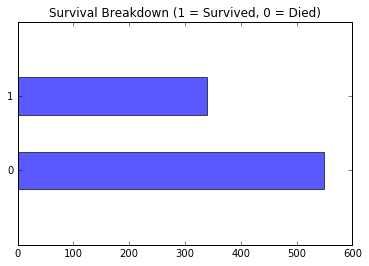

In [93]:
# Survived counts
plt.figure(figsize=(6,4))
fig, ax = plt.subplots()
train_data.Survived.value_counts().plot(kind='barh', color="blue", alpha=.65)
ax.set_ylim(-1, len(train_data.Survived.value_counts())) 
plt.title("Survival Breakdown (1 = Survived, 0 = Died)")

Now I want to plot survival by fare amount per person.

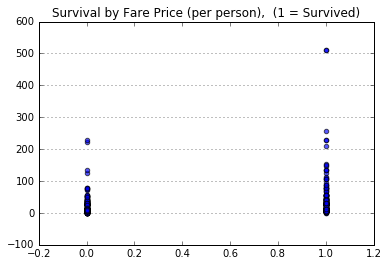

In [94]:
plt.figure(figsize=(6,4))
plt.scatter(train_data.Survived, train_data.FarePP, alpha=0.65)
plt.grid(b=True, which='major', axis='y')  
plt.title("Survival by Fare Price (per person),  (1 = Survived)")

In [95]:
highclass=train_data.FarePP[train_data.Pclass==1].values
midclass=train_data.FarePP[train_data.Pclass==2].values
lowclass=train_data.FarePP[train_data.Pclass==3].values

{'boxes': [<matplotlib.lines.Line2D at 0xc020630>],
 'caps': [<matplotlib.lines.Line2D at 0xc02e390>,
 'fliers': [<matplotlib.lines.Line2D at 0xc03b438>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0xc02ee80>],
 'whiskers': [<matplotlib.lines.Line2D at 0xc0207f0>,
  <matplotlib.lines.Line2D at 0xc020dd8>]}

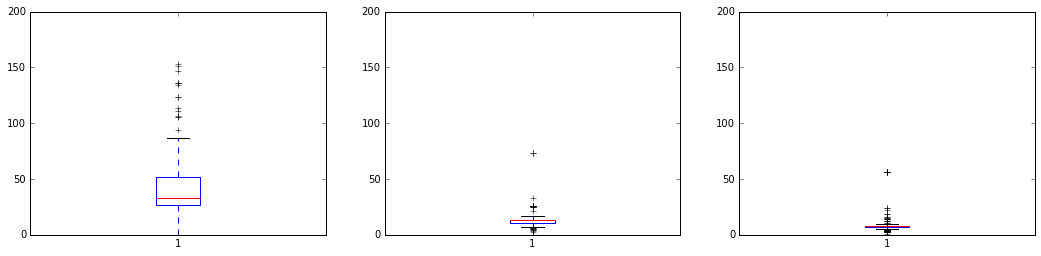

In [96]:
fig = plt.figure(figsize=(18,4), dpi=1600)
alpha_level = 0.65

ax1 = fig.add_subplot(131)
ax1.set_ylim([0,200])
ax1.boxplot(highclass)

ax2 = fig.add_subplot(132, sharey=ax1)
ax2.set_ylim([0,200])
ax2.boxplot(midclass)

ax3 = fig.add_subplot(133, sharey=ax1)
ax3.set_ylim([0,200])
ax3.boxplot(lowclass)

After all that, how about 0-100 by 10s?

In [97]:
def bin_fares(fare, fmax=100, bsize=10):
    if fare < max:
        return fare // bsize
    else:
        return 100 // bsize

In [98]:
train_data['Farebin'] = train_data['FarePP'].apply(bin_fares)

In [99]:
train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Fare,Embarked,Gender,AgeFill,AgeClass,FamSize,FarePP,Farebin
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,7.2500,S,1,22.0,66.0,1,3.62500,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,71.2833,C,0,38.0,38.0,1,35.64165,3.0
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,7.9250,S,0,26.0,78.0,0,7.92500,0.0


## 2.1 Age banding

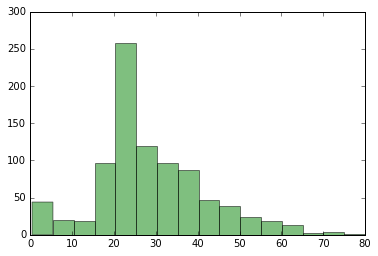

In [100]:
n,bins,patches = plt.hist(train_data['AgeFill'].values,bins=16,facecolor='green',alpha=0.5)

So let's put 15 and under together.

In [101]:
def age_banding(age):
    if age <= 15:
        return 0
    else:
        return (age // 5) - 2

In [102]:
train_data['AgeBand'] = train_data['AgeFill'].apply(age_banding)

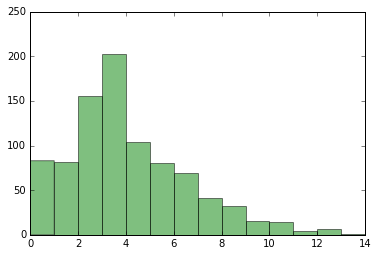

In [103]:
n,bins,patches = plt.hist(train_data['AgeBand'].values,bins=14,facecolor='green',alpha=0.5)

# 3. More ground work

Now I think I'm ready.

In [104]:
features = ['Pclass','Gender','FamSize','Farebin','AgeBand']

## 3.1 One-hot encode these features

In [115]:
data = train_data[features]

In [116]:
data.head(3)

,Pclass,Gender,FamSize,Farebin,AgeBand
0,3,1,1,0.0,2.0
1,1,0,1,3.0,5.0
2,3,0,0,0.0,3.0


In [117]:
for f in features:
    data_enc = pd.get_dummies(data[f],prefix=f)
    data = data.drop(f, axis=1)
    data = data.join(data_enc)

In [125]:
data = data.join(train_data['Survived'])

In [126]:
data.head(3)

,Pclass_1,Pclass_2,Pclass_3,Gender_0,Gender_1,FamSize_0,FamSize_1,FamSize_2,FamSize_3,FamSize_4,...,AgeBand_5.0,AgeBand_6.0,AgeBand_7.0,AgeBand_8.0,AgeBand_9.0,AgeBand_10.0,AgeBand_11.0,AgeBand_12.0,AgeBand_14.0,Survived
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [127]:
train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Fare,Embarked,Gender,AgeFill,AgeClass,FamSize,FarePP,Farebin,AgeBand
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,7.2500,S,1,22.0,66.0,1,3.62500,0.0,2.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,71.2833,C,0,38.0,38.0,1,35.64165,3.0,5.0
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,7.9250,S,0,26.0,78.0,0,7.92500,0.0,3.0


# 4. Now the fun begins

## 4.1 sklearn's Adaboost

Totally just going to use sklearn to try it out.

In [136]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [162]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),algorithm="SAMME",n_estimators=200)

In [163]:
Y = data['Survived'].values

In [164]:
X = data.drop('Survived',axis=1).values

In [165]:
bdt.fit(X,Y)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=200, random_state=None)

In [166]:
train_data['Predictions'] = bdt.predict(X)

In [167]:
len(train_data[train_data['Survived']==train_data['Predictions']])

730

In [146]:
len(train_data)

889

# 5. Now try it on test data

## 5.1 Now we need to clean up test data the same way

In [177]:
test_data = pd.read_csv('D:\\Jason\\Data\\titanic\\test.csv',header=0)

In [178]:
test_data = test_data.drop(['Ticket','Cabin'],axis=1)

In [179]:
test_data['Gender'] = test_data['Sex'].map({'female':0,'male':1}).astype(int)

In [180]:
median_ages = np.zeros((2,3))
train_data['AgeFill'] = test_data['Age']
for i in range(0,2):
    for j in range(0,3):
        median_ages[i,j] = test_data[(test_data['Gender'] == i) & \
                              (test_data['Pclass'] == j+1)]['Age'].dropna().median()
        test_data.loc[ (test_data.Age.isnull()) & (test_data.Gender==i) & (test_data.Pclass==j+1),\
                      'AgeFill']=median_ages[i,j]

In [181]:
len(test_data)

418

In [183]:
test_data['AgeClass']=test_data['AgeFill']*test_data['Pclass']
test_data['FamSize']=test_data['SibSp']+test_data['Parch']
test_data['FarePP']=test_data['Fare'] / (test_data['FamSize']+1)

In [184]:
test_data['Farebin'] = test_data['FarePP'].apply(bin_fares)
test_data['AgeBand'] = test_data['AgeFill'].apply(age_banding)

In [185]:
datatest = test_data[features]

In [187]:
for f in features:
    data_enc = pd.get_dummies(datatest[f],prefix=f)
    datatest = datatest.drop(f, axis=1)
    datatest = datatest.join(data_enc)

In [190]:
datatest.head(3)

,Pclass_1,Pclass_2,Pclass_3,Gender_0,Gender_1,FamSize_0,FamSize_1,FamSize_2,FamSize_3,FamSize_4,...,Farebin_13.0,Farebin_15.0,Farebin_16.0,Farebin_21.0,Farebin_22.0,Farebin_25.0,Farebin_26.0,AgeBand_2.0,AgeBand_3.0,AgeBand_6.0
0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [188]:
Xtest = datatest.values

In [189]:
test_data['Survived']=bdt.predict(Xtest)

ValueError: Number of features of the model must  match the input. Model n_features is 48 and  input n_features is 36 